In [1]:
from simulation import citygraph_dataset
# from learning import inductive_route_learning, eval_route_generator, bee_colony
from learning.bee_colony import main as main_bee  # я так обозвал
from learning.eval_route_generator import main as main_eval # я так обозвал
from omegaconf import OmegaConf, DictConfig
from simulation import drawing

from tqdm import tqdm
from pathlib import Path

In [2]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
import os

cfg_dir = os.path.abspath("../TNDP_learning/cfg")

In [3]:
dataset = citygraph_dataset.DynamicCityGraphDataset(
    min_nodes=15,
    max_nodes=15,
    edge_keep_prob=0.7,
    data_type=citygraph_dataset.MIXED,  # or any other type you want
    directed=False,
    fully_connected_demand=True,  # default SIDE_LENGTH_M
    mumford_style=True,
    pos_only=False
)

# Generate graphs
n_graphs = 3  # number of graphs you want to generate
graphs = [dataset.generate_graph(draw=False) for _ in tqdm(range(n_graphs))]

100%|██████████| 3/3 [00:00<00:00, 122.86it/s]


In [4]:
import numpy as np

data_np = graphs[0]['street_adj'].numpy()
np.savetxt("CEC2013Supp/Instances/MandlTrolleybusTravelTimes.txt", data_np, fmt="%.4f", delimiter=" ")


data_np = graphs[1]['street_adj'].numpy()
np.savetxt("CEC2013Supp/Instances/MandlTrolleyTravelTimes.txt", data_np, fmt="%.4f", delimiter=" ")


data_np = graphs[2]['street_adj'].numpy()
np.savetxt("CEC2013Supp/Instances/MandlBusTravelTimes.txt", data_np, fmt="%.4f", delimiter=" ")

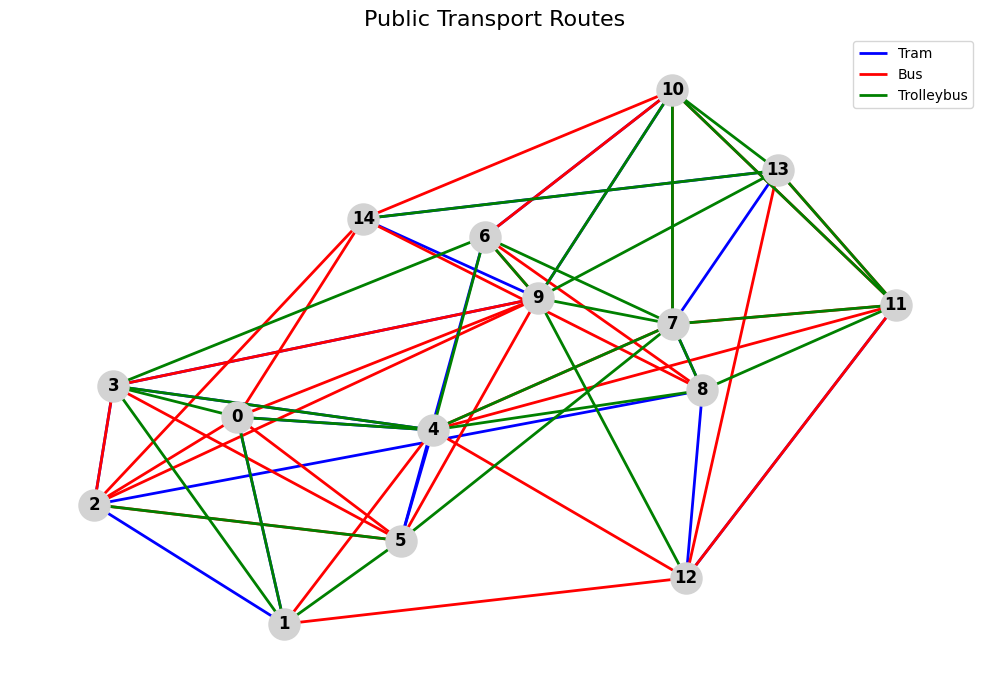

In [5]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

tram = graphs[0]['street_adj']
bus = graphs[1]['street_adj']
trolleybus = graphs[2]['street_adj']

# ====== Функция для построения графа без inf ======
def matrix_to_graph(matrix):
    G = nx.Graph()
    n = matrix.shape[0]
    for i in range(n):
        for j in range(i+1, n):
            if matrix[i, j] != np.inf and matrix[i, j] != 0:
                G.add_edge(i, j, weight=matrix[i, j])
    return G

# ====== Построение всех графов ======
G_tram = matrix_to_graph(tram)
G_bus = matrix_to_graph(bus)
G_trolley = matrix_to_graph(trolleybus)

# ====== Общие координаты для всех ======
# Берём объединённый граф, чтобы layout совпадал
G_all = nx.compose_all([G_tram, G_bus, G_trolley])
pos = nx.spring_layout(G_all, seed=42)

# ====== Отрисовка в одной figure ======
plt.figure(figsize=(10, 7))

# Рисуем узлы (один раз)
nx.draw_networkx_nodes(G_all, pos, node_color="lightgray", node_size=500)
nx.draw_networkx_labels(G_all, pos, font_size=12, font_weight="bold")

# Рисуем рёбра каждого вида транспорта
nx.draw_networkx_edges(G_tram, pos, edge_color="blue", width=2, label="Tram")
nx.draw_networkx_edges(G_bus, pos, edge_color="red", width=2, label="Bus")
nx.draw_networkx_edges(G_trolley, pos, edge_color="green", width=2, label="Trolleybus")

# Оформление
plt.title("Public Transport Routes", fontsize=16)
plt.axis("off")
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import os
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf
from learning.eval_route_generator import main as main_eval
from learning.bee_colony import main as main_bee

def run_eval_and_bee(
    dataset_name='mandlbus',
    demand_time_weight=0.33,
    route_time_weight=0.33,
    median_connectivity_weight=0.33,
    model_weights='../TNDP_learning/output/inductive_random_graphs_checkpoints/iter990.pt',
    cfg_dir=os.path.abspath('../TNDP_learning/cfg')
):
    """
    Функция для последовательного запуска main_eval и main_bee neuro
    
    Параметры:
    - dataset_name: Название датасета (например, 'mandlbus').
    - demand_time_weight: Вес для demand_time в cost_function.
    - route_time_weight: Вес для route_time в cost_function.
    - median_connectivity_weight: Вес для median_connectivity в cost_function.
    - model_weights: Путь к весам модели.
    - cfg_dir: Путь к директории с конфигами Hydra.
    
    Возвращает:
    - metrics_eval, unserved_demand_eval: Результаты от main_eval.
    - metrics_bee, unserved_demand_bee: Результаты от main_bee.
    """
    experiment_name = f'exp_multimodal_{dataset_name}_pp_{demand_time_weight}_op_{route_time_weight}_cp_{median_connectivity_weight}'
    initial_routes_name = experiment_name + '_starting'
    generated_routes_name = experiment_name + '_generated'

    with initialize_config_dir(config_dir=cfg_dir, version_base=None):
        cfg_eval = compose(
            config_name="eval_model_mumford",
            overrides=[
                f"+eval={dataset_name}",
                f"+model.weights={model_weights}",
                f"++run_name={initial_routes_name}",
                f"++experiment.cost_function.kwargs.demand_time_weight={demand_time_weight}",
                f"++experiment.cost_function.kwargs.route_time_weight={route_time_weight}",
                f"++experiment.cost_function.kwargs.median_connectivity_weight={median_connectivity_weight}"
            ]
        )

    metrics_eval, unserved_demand_eval = main_eval(cfg_eval)

    with initialize_config_dir(config_dir=cfg_dir, version_base=None):
        cfg_neural = compose(
            config_name="neural_bco_mumford",
            overrides=[
                f"+eval={dataset_name}",
                f"+model.weights={model_weights}",
                f"++run_name={generated_routes_name}",
                f"++experiment.cost_function.kwargs.demand_time_weight={demand_time_weight}",
                f"++experiment.cost_function.kwargs.route_time_weight={route_time_weight}",
                f"++experiment.cost_function.kwargs.median_connectivity_weight={median_connectivity_weight}",
                f"init.path=output_routes/nn_construction_{initial_routes_name}_routes.pkl",
            ]
        )

    metrics_bee, unserved_demand_bee = main_bee(cfg_neural)

    return metrics_eval, unserved_demand_eval, metrics_bee, unserved_demand_bee

# Для автобусов

In [7]:
dataset_name = 'mandlbus'
demand_time_weight = 0.33
route_time_weight = 0.33
median_connectivity_weight = 0.33
experiment_name = f'exp_multimodal_{dataset_name}_pp_{demand_time_weight}_op_{route_time_weight}_cp_{median_connectivity_weight}'
initial_routes_name = experiment_name+ '_starting'
generated_routes_name = experiment_name + '_generated'

In [8]:
metrics_eval, unserved_demand_eval, metrics_bee, unserved_demand_bee = run_eval_and_bee(
    dataset_name=dataset_name,
    demand_time_weight=demand_time_weight,
    route_time_weight=route_time_weight,
    median_connectivity_weight=median_connectivity_weight
)

/root/TNDP_learning/learning/utils.py:321: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1831.)
  out_stats = (final_costs.mean(), final_costs.std(), unserved_demand,  metrics)


In [9]:
import pickle

with open(f'output_routes/neural_bco_{generated_routes_name}_routes.pkl', 'rb') as file:
    data = pickle.load(file)
print(data)

[tensor([[12,  9,  6,  3,  0, -1],
        [13, 11,  8,  4,  0,  1]])]


In [14]:
unserved_demand_bee

tensor([[[  0.,   0., 200.,   0.,   0., 150.,   0.,  75.,   0.,   0.,  30.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,  50.,   0.,   0., 180.,   0.,  90.,   0.,   0.,  20.,
            0.,   0.,   0.,   0.],
         [200.,  50.,   0.,  40.,  60., 180.,  90.,  90.,  15.,  45.,  20.,
           10.,  10.,   5.,   0.],
         [  0.,   0.,  40.,   0.,   0., 100.,   0.,  50.,   0.,   0.,  40.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,  60.,   0.,   0.,  50.,   0.,  25.,   0.,   0.,  20.,
            0.,   0.,   0.,   0.],
         [150., 180., 180., 100.,  50.,   0., 100., 100.,  30., 880.,  60.,
           15.,  15.,  10.,   0.],
         [  0.,   0.,  90.,   0.,   0., 100.,   0.,  50.,   0.,   0.,  35.,
            0.,   0.,   0.,   0.],
         [ 75.,  90.,  90.,  50.,  25., 100.,  50.,   0.,  15., 440.,  35.,
           10.,  10.,   5.,   0.],
         [  0.,   0.,  15.,   0.,   0.,  30.,   0.,  15.,   0.,   0.,  20.,
            0.,   0.,   0.,   0.],
 

Сохраняем спрос чтобы подтянуть его из файла дальше (название траспорта должно совпадать при сохранении файла и при запуске модели MandlTrolleybusDemand и dataset_name = 'mandltrolleybus')

In [11]:
data_np = unserved_demand_bee[0].numpy()
np.savetxt("CEC2013Supp/Instances/MandlTrolleybusDemand.txt", data_np, fmt="%.4f", delimiter=" ")

In [12]:
# Порядок нужных ключей
metrics_bee['median_connectivity'] /= 60 
keys_order = ['ATT', 'RTT', 'median_connectivity', 'cost', '$d_{un}$', '$d_0$', '$d_1$', '$d_2$']

print('\t'.join(str(key) for key in keys_order))
print('\t'.join(str(round(metrics_bee[key].item(),3)) for key in keys_order))

ATT	RTT	median_connectivity	cost	$d_{un}$	$d_0$	$d_1$	$d_2$
2056.077	14161.895	2670.268	4.392	54.721	28.195	17.084	0.0


# Для Троллейбусов

Если после работы предыдущей модели спроса не останется, то следующий запуск выдаст ошибку

In [17]:
dataset_name = 'mandltrolleybus'
demand_time_weight = 0.33
route_time_weight = 0.33
median_connectivity_weight = 0.33
experiment_name = f'exp_multimodal_{dataset_name}_pp_{demand_time_weight}_op_{route_time_weight}_cp_{median_connectivity_weight}'
initial_routes_name = experiment_name+ '_starting'
generated_routes_name = experiment_name + '_generated'

metrics_eval, unserved_demand_eval, metrics_bee, unserved_demand_bee = run_eval_and_bee(
    dataset_name=dataset_name,
    demand_time_weight=demand_time_weight,
    route_time_weight=route_time_weight,
    median_connectivity_weight=median_connectivity_weight
)

In [18]:
import pickle

with open(f'output_routes/neural_bco_{generated_routes_name}_routes.pkl', 'rb') as file:
    data = pickle.load(file)
print(data)

[tensor([[ 4,  3,  2,  8,  7, 13],
        [ 5,  6, 10,  9, 14, 13]])]


In [19]:
unserved_demand_bee

tensor([[[  0.,   0., 200.,   0.,   0., 150.,   0.,  75.,   0.,   0.,  30.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,  50.,   0.,   0., 180.,   0.,  90.,   0.,   0.,  20.,
            0.,   0.,   0.,   0.],
         [200.,  50.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           10.,  10.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
         [150., 180.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           15.,  15.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
         [ 75.,  90.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           10.,  10.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
 

In [20]:
data_np = unserved_demand_bee[0].numpy()
np.savetxt("CEC2013Supp/Instances/MandlTrolleyDemand.txt", data_np, fmt="%.4f", delimiter=" ")

In [21]:
# Порядок нужных ключей
metrics_bee['median_connectivity'] /= 60 
keys_order = ['ATT', 'RTT', 'median_connectivity', 'cost', '$d_{un}$', '$d_0$', '$d_1$', '$d_2$']

print('\t'.join(str(key) for key in keys_order))
print('\t'.join(str(round(metrics_bee[key].item(),3)) for key in keys_order))

ATT	RTT	median_connectivity	cost	$d_{un}$	$d_0$	$d_1$	$d_2$
893.849	6032.489	1122.741	3.097	24.296	47.066	28.638	0.0


# Для Трамваев

In [22]:

dataset_name = 'mandltrolley'
demand_time_weight = 0.33
route_time_weight = 0.33
median_connectivity_weight = 0.33
experiment_name = f'exp_multimodal_{dataset_name}_pp_{demand_time_weight}_op_{route_time_weight}_cp_{median_connectivity_weight}'
initial_routes_name = experiment_name+ '_starting'
generated_routes_name = experiment_name + '_generated'

metrics_eval, unserved_demand_eval, metrics_bee, unserved_demand_bee = run_eval_and_bee(
    dataset_name=dataset_name,
    demand_time_weight=demand_time_weight,
    route_time_weight=route_time_weight,
    median_connectivity_weight=median_connectivity_weight
)


In [26]:
import pickle

with open(f'output_routes/neural_bco_{generated_routes_name}_routes.pkl', 'rb') as file:
    data = pickle.load(file)
print(data)

[tensor([[ 5,  2, 14, 10, 11, 12,  1],
        [11,  7, 10, 14,  0,  2, -1]])]


In [27]:
unserved_demand_bee

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

In [28]:
# Порядок нужных ключей
metrics_bee['median_connectivity'] /= 60 
keys_order = ['ATT', 'RTT', 'median_connectivity', 'cost', '$d_{un}$', '$d_0$', '$d_1$', '$d_2$']

print('\t'.join(str(key) for key in keys_order))
print('\t'.join(str(round(metrics_bee[key].item(),3)) for key in keys_order))

ATT	RTT	median_connectivity	cost	$d_{un}$	$d_0$	$d_1$	$d_2$
1677.758	13772.864	25.468	2.633	0.0	75.845	24.155	0.0
